# Example with high-resolution CMIP6 models (~100 km) using Pangeo catalog 

### Time period

We will use data from 1985 to 2014.

### Variables 

| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
|  prsn         |    Snowfall Flux                        | [kg m-2 s-1]  | surface |
| clw           |    Mass Fraction of Cloud Liquid Water  |  [kg kg-1]    |    ml   |
| cli           |    Mass Fraction of Cloud Ice           | [kg kg-1]     |    ml   |
| tas           |    Near-Surface Air Temperature         |   [K]         | surface |
| ta            |    Air Temperature                      |  [K]          |    ml   |
| clivi         |    Ice Water Path                       | [kg m-2]      |         |
| lwp           |    Liquid Water Path                    | [kg m-2]      |         |


## Import python packages

In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
import sys
sys.path.append('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/')

import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import cartopy.crs as ccrs
import cartopy as cy
import matplotlib.pyplot as plt
import xesmf as xe
from glob import glob
import pandas as pd
import numpy as np
from cmcrameri import cm

import functions as fct


%matplotlib inline


# reload imports
%load_ext autoreload
%autoreload 2

### Open CMIP6 online catalog

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,517667
dcpp_init_year,60


### Search correspnding data

In [3]:
list_models = [
    'NorESM2-MM', 
    'TaiESM1',
    'EC-Earth3-AerChem',
    'GFDL-ESM4'
    ]



In [63]:
variable_id=[
            #  'prsn', 
            #  'clivi',
            # 'lwp',
            'tas'

             ]
cat = col.search(source_id=list_models, experiment_id=['historical'], variable_id=variable_id[0], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,3hr,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
1,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,day,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
2,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
3,CMIP,NCC,NorESM2-MM,historical,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-MM/historica...,NaN,20191108
4,CMIP,NCC,NorESM2-MM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-MM/historica...,NaN,20191108
5,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/AS-RCEC/TaiESM1/historic...,NaN,20200623
6,CMIP,EC-Earth-Consortium,EC-Earth3-AerChem,historical,r1i1p1f1,day,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200624
7,CMIP,EC-Earth-Consortium,EC-Earth3-AerChem,historical,r1i1p1f1,3hr,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200624
8,CMIP,EC-Earth-Consortium,EC-Earth3-AerChem,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200624
9,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/AS-RCEC/TaiESM1/historic...,NaN,20200626


In [64]:
cat.df['source_id'].unique()

array(['GFDL-ESM4', 'NorESM2-MM', 'TaiESM1', 'EC-Earth3-AerChem'],
      dtype=object)

### Create dictionary from the list of datasets we found

- This step may take several minutes so be patient!

In [65]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [66]:
list(dset_dict.keys())

['CMIP.NCC.NorESM2-MM.historical.Amon.gn',
 'CMIP.AS-RCEC.TaiESM1.historical.Amon.gn',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1',
 'CMIP.NCC.NorESM2-MM.historical.day.gn',
 'CMIP.AS-RCEC.TaiESM1.historical.day.gn',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.day.gr1',
 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.day.gr',
 'CMIP.AS-RCEC.TaiESM1.historical.3hr.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.3hr.gr',
 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Amon.gr',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.3hr.gr1']

### Use data as xarray to make a simple plot

In [67]:
if variable_id[0] == 'lwp':
    ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn']
else:
    ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn']
ds

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, member_id: 1, time: 1980)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 408, 192, 288), meta=np.ndarray>
Attributes: (12/54)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1200-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     438000.0
    ...                        ...
    variable_id:               tas
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/b726dcce-04e7-41ef-8f32-a36cffa51...
    version_id:                v20191108
    intake_esm_varname:        ['tas']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-MM.historical.Amon.gn

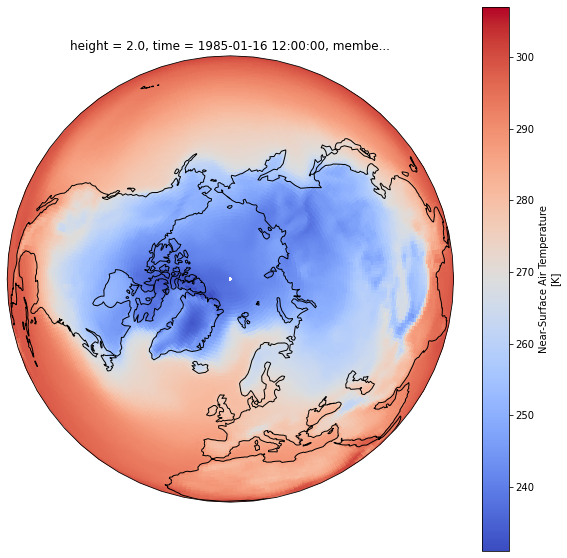

In [68]:
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()
ds[variable_id[0]].sel(time=cftime.DatetimeNoLeap(1985, 1, 16, 12, 0, 0, 0)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

### Get attributes (unique identifier)

In [69]:
ds.attrs['tracking_id']

'hdl:21.14100/b726dcce-04e7-41ef-8f32-a36cffa516bd\nhdl:21.14100/69786839-c0a1-45de-935b-13a04e382fd7\nhdl:21.14100/9e97d612-10a7-458a-980e-fe4d4cac4bdb\nhdl:21.14100/0d51a98d-e849-48ae-82b4-9b2fb8f8c223\nhdl:21.14100/0966ef7c-613e-4fcc-81f5-c7e0811a8f34\nhdl:21.14100/f4ac8ec2-30a2-4cb4-a7f6-c501e812baf6\nhdl:21.14100/0daf9460-21f8-48a5-930d-cc1f74812994\nhdl:21.14100/bda027e9-7c49-44f5-bb08-52e8b14e612d\nhdl:21.14100/6e3ad453-fcaf-4e39-873b-e19fa777337a\nhdl:21.14100/c803cdd9-03f8-468a-add6-f1dbb3e0821d\nhdl:21.14100/20dfef18-620f-45c7-9d4b-1a6b2e4cb865\nhdl:21.14100/a176839c-d91a-4523-b272-61a65a73fb78\nhdl:21.14100/808c535a-b500-4424-a9bb-5f967c257748\nhdl:21.14100/a04a6234-f33c-4039-b6f7-509966fe357b\nhdl:21.14100/45c7759d-86c5-442f-a211-089103fa5868\nhdl:21.14100/217c9a68-8d35-42e7-a7ed-69035697043f\nhdl:21.14100/c9b183a4-5812-4b4e-af0a-497a68180979'

# Regrid CMIP6 data to common NorESM2-MM grid

In [70]:
def to_DatetimeNoLeap(da):
    '''Takes a DataArray. Change the 
    calendar to DatetimeNoLeap.
    https://climate-cms.org/2019/11/12/Calendars-and-monthly-data.html'''
    val = da.copy()
    time1 = da.time.copy()
    for itime in range(val.sizes['time']):
        bb = val.time.values[itime].timetuple()
        time1.values[itime] = cftime.DatetimeNoLeap(bb[0],bb[1],15, 12)

    # We rename the time dimension and coordinate to time360 to make it clear it isn't 
    # the original time coordinate.
    val = val.rename({'time':'time'})
    time1 = time1.rename({'time':'time'})
    val = val.assign_coords({'time':time1})
    return val


In [71]:
starty = 1985; endy = 2014
year_range = range(starty, endy+1)

# create dictionary for reggridded data
ds_gridded_dict = dict()

# Read in the output grid from NorESM
if variable_id[0] == 'lwp':
    ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn'].isel(member_id = 0)
else:
    ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn'].isel(member_id = 0)
ds_out = ds_out.sel(time = ds_out.time.dt.year.isin(year_range)).squeeze()

counter = 0




for keys in dset_dict.keys():
    # select only models which have atmospheric monthly values
    amon = keys.split('.')[-2]
    if amon == 'Amon' or amon == 'AERmon': 
        # select model name 
        model = keys.split('.')[2]
        
        # select where data should be saved
        filename = '{}_Amon_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
        savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/{}/'.format(model)
        nc_out = savepath + filename
        files = glob(nc_out)
        
        if nc_out in files:
        #     print('{} is downloaded'.format(nc_out))
        #     counter += 1
        #     print('Have regridded in total: {:} files'.format(str(counter)))
        # else:
            
            # Input data from CMIP6 model to be regridded
            ds_in = dset_dict[keys].isel(member_id = 0)
            ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()
            
            # common time grid
            ds_in = to_DatetimeNoLeap(ds_in)
            
            
            # Regrid data
            ds_in_regrid = fct.regrid_data(ds_in, ds_out)
            
            # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
            ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
            ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)
            

            
            # create dataset with all models
            ds_gridded_dict[model] = ds_in_regrid
            ds_in_regrid.close(); ds_in.close(); ds_out.close()
            
            # # Save to netcdf file
            # ds_in_regrid.to_netcdf(nc_out)
            # print('file written: {}'.format(nc_out))

tas True
tas True
tas True
tas True


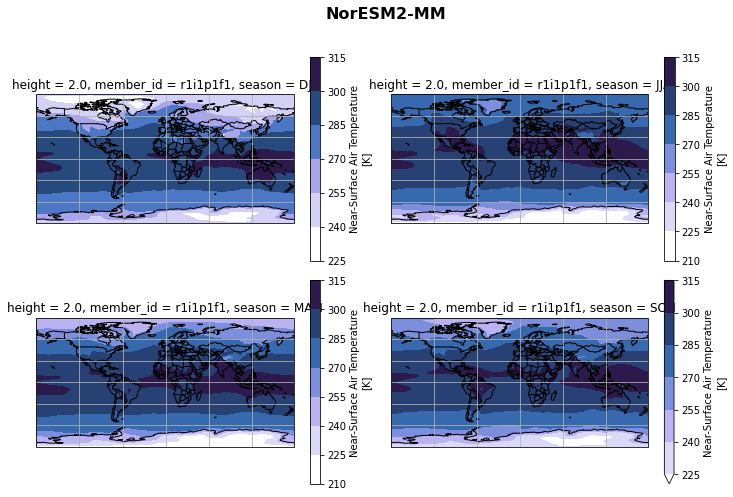

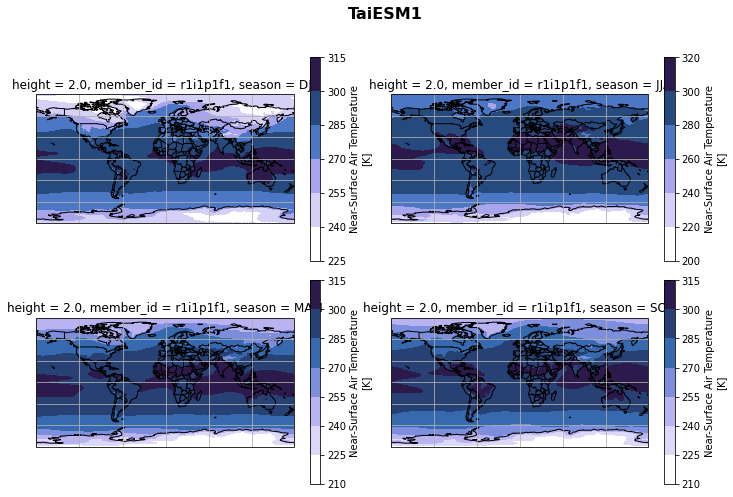

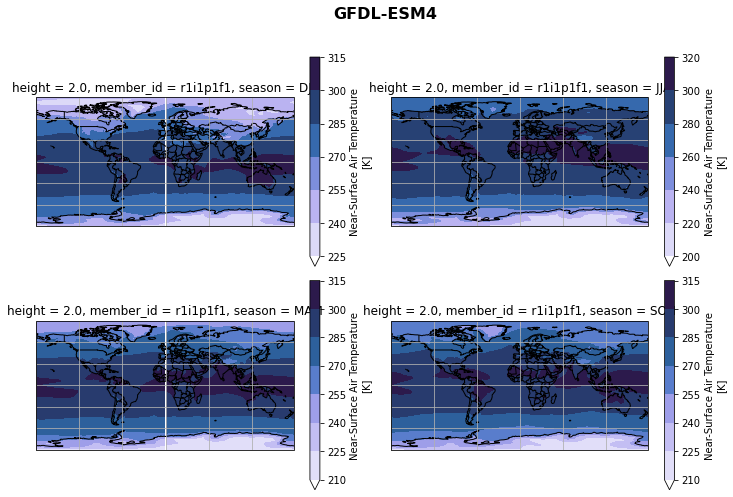

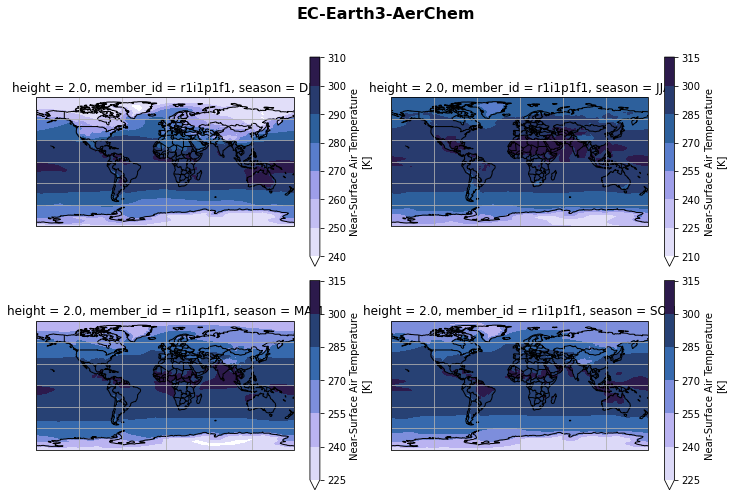

In [72]:
for model in ds_gridded_dict.keys():
    _smean = ds_gridded_dict[model][variable_id[0]].groupby('time.season').mean('time', keep_attrs=True)

    fig, axsm = plt.subplots(2,2, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
    fig.suptitle(model, fontsize=16, fontweight="bold")
    axs = axsm.flatten()

    for ax, i in zip(axs, _smean.season):
        if variable_id[0] == 'prsn':
            # plot seasonal mean and convert kg m-2 s-1 to mm/day
            (_smean.sel(season = i)*86400).plot.contourf(ax=ax, 
                                        transform=ccrs.PlateCarree(),
                                        cmap=cm.devon_r, 
                                        robust=True)
        else:
            (_smean.sel(season = i)).plot.contourf(ax=ax, 
                                        transform=ccrs.PlateCarree(),
                                        cmap=cm.devon_r, 
                                        robust=True)

        ax.coastlines()
        gl = ax.gridlines()
        ax.add_feature(cy.feature.BORDERS);
        gl.top_labels = False

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)

In [73]:
ds_gridded_dict.keys()

dict_keys(['NorESM2-MM', 'TaiESM1', 'GFDL-ESM4', 'EC-Earth3-AerChem'])

# Connect all models into one Dataset with new coordinate 'model'

In [74]:
_ds = list(ds_gridded_dict.values())
_coord = list(ds_gridded_dict.keys())
ds_prsn_cmip = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})
ds_prsn_cmip = ds_prsn_cmip.drop('bnds')

# savet to netcdf
filename = '{}_Amon_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/'
nc_out = savepath + filename
files = glob(nc_out)

counter = 0 
# Save to netcdf file
if nc_out in files:
    print('{} is downloaded'.format(nc_out))
    counter += 1
    print('Have saved in total: {:} files'.format(str(counter)))
else:
    ds_prsn_cmip.to_netcdf(nc_out)
    print('file written: .{}'.format(nc_out))

/scratch/franzihe/output/CMIP6_hist/1deg/tas_Amon_1deg_198501_201412.nc is downloaded
Have saved in total: 1 files


# Create model and seasonal mean of all regridded models

In [75]:
prsn = ds_prsn_cmip.mean('model', keep_attrs=True, skipna = True).groupby('time.season').mean('time', keep_attrs=True, skipna = True)

# savet to netcdf
filename = '{}_season_1deg_{}_{}.nc'.format(variable_id[0], starty, endy)
nc_out = savepath + filename
files = glob(nc_out)

counter = 0 
# Save to netcdf file
if nc_out in files:
    print('{} is downloaded'.format(nc_out))
    counter += 1
    print('Have saved in total: {:} files'.format(str(counter)))
else:
    prsn.to_netcdf(nc_out)
    print('file written: .{}'.format(nc_out))

/scratch/franzihe/output/CMIP6_hist/1deg/tas_season_1deg_1985_2014.nc is downloaded
Have saved in total: 1 files


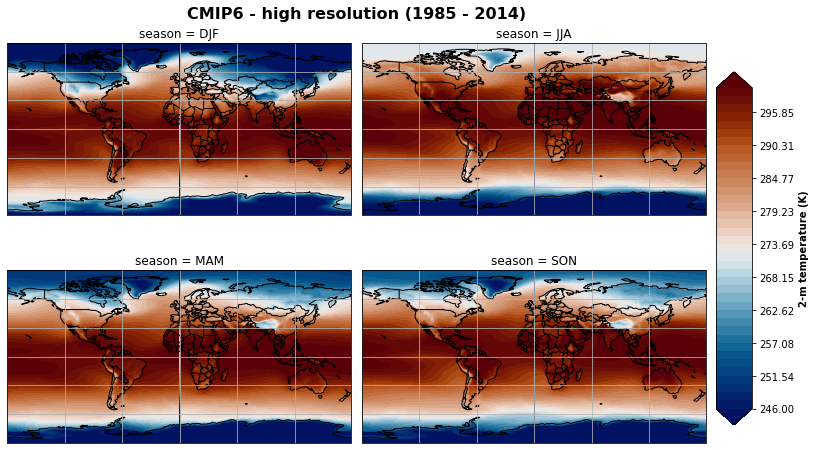

In [76]:
fig, axsm = plt.subplots(2,2, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
fig.suptitle('CMIP6 - high resolution (1985 - 2014)', fontsize=16, fontweight="bold")

axs = axsm.flatten()
for ax, i in zip(axs, prsn.season):
    if variable_id[0] == 'prsn':
        im = (prsn[variable_id[0]].sel(season = i)*86400).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.devon_r,
                                     robust=True,
                                     vmin = 0, vmax=2.5, 
                                     levels = 25,
                                     add_colorbar = False,
                                     extend = 'max')
    elif variable_id[0] == 'clivi' or variable_id[0] == 'lwp':
        im = (prsn[variable_id[0]].sel(season = i)*1000).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.devon_r,
                                     robust=True,
                                     vmin = 0, vmax=100, 
                                     levels = 25,
                                     add_colorbar = False,
                                     extend = 'max')
    elif variable_id[0] == 'tas':
        im = prsn[variable_id[0]].sel(season = i).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.vik,
                                     robust=True,
                                     vmin = 246 , vmax=300, 
                                     levels = 40,
                                     add_colorbar = False,
                                     extend = 'both')


    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl.top_labels = False

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)




if variable_id[0] == 'prsn':
    cb.set_label(label='Snowfall (mm$\,$day$^{-1}$)', weight='bold') 
elif variable_id[0] == 'clivi':
    cb.set_label(label='Ice Water Path (g$\,$m$^{-2}$)', weight='bold')
elif variable_id[0] == 'lwp':
    cb.set_label(label='Liquid Water Path (g$\,$m$^{-2}$)', weight='bold')
elif variable_id[0] == 'tas':
    cb.set_label(label='2-m temperature (K)', weight='bold')


plt.tight_layout()
fig.subplots_adjust(top=1)

# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)
